In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from krxns.net_construction import construct_reaction_network, extract_compounds
from krxns.config import filepaths
from krxns.utils import str2int
from krxns.networks import SuperMultiDiGraph
import json
from scipy.stats import spearmanr
from itertools import chain
from collections import defaultdict

In [2]:
# Load unpaired cofactors
with open(filepaths['cofactors'] / 'expanded_unpaired_cofactors.json', 'r') as f:
    unpaired_cofactors = json.load(f)

# Load known reaction data
with open(filepaths['data'] / 'sprhea_240310_v3_mapped.json', 'r') as f:
    krs = json.load(f)

# Load op connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_operator.json', 'r') as f:
    op_cxns = str2int(json.load(f))

# Load sim connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_similarity.json', 'r') as f:
    sim_cxn = str2int(json.load(f))

with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_side_counts.json', 'r') as f:
    side_counts = str2int(json.load(f))

# Load coreactant whitelist
with open(filepaths['cofactors'] / 'pickaxe_whitelist.json', 'r') as f:
    coreactant_whitelist = json.load(f)

# Get known compounds
kcs, smi2id = extract_compounds(krs)

tani_sim_mat = np.load(filepaths['sim_mats'] / "tanimoto.npy")

In [3]:
atom_lb = 0.0
cw = coreactant_whitelist

G = SuperMultiDiGraph()
edges, nodes = construct_reaction_network(
    operator_connections=op_cxns,
    similarity_connections=sim_cxn,
    side_counts=side_counts,
    reactions=krs,
    unpaired_cofactors=unpaired_cofactors,
    connect_nontrivial=False,
    atom_lb=atom_lb,
    coreactant_whitelist=cw
)
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [4]:
paths = nx.shortest_path(G)

# Filter out self-paths
tmp = {}
for i in paths:
    destinations = {j: elt for j, elt in paths[i].items() if i != j}
    if destinations:
        tmp[i] = destinations
paths = tmp

<class 'networkx.utils.decorators.argmap'> compilation 4:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


In [35]:
path_tanis = defaultdict(dict)
path_tanis_all_successors = defaultdict(dict)
n_paths = 0
ds = 100
for i in list(paths.keys())[::ds]:
    for j in paths[i]:
        col_idxs = paths[i][j]
        path_tanis[i][j] = tani_sim_mat[j, col_idxs]

        if len(col_idxs) > 2:
            succ_scores = [tani_sim_mat[j, list(G.successors(c))] for c in col_idxs[:-2]]
            path_tanis_all_successors[i][j] = succ_scores
        
        n_paths += 1
print(f"# paths = {n_paths}")

# paths = 63301


In [36]:
ds = 1
path_spearmans = {}
for i in list(path_tanis.keys())[::ds]:
    path_spearmans[i] = {}
    for j in path_tanis[i]:
        tanis = path_tanis[i][j]
        path_spearmans[i][j] = spearmanr(np.arange(len(tanis)), tanis).statistic

/tmp/ipykernel_485905/16506368.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  path_spearmans[i][j] = spearmanr(np.arange(len(tanis)), tanis).statistic


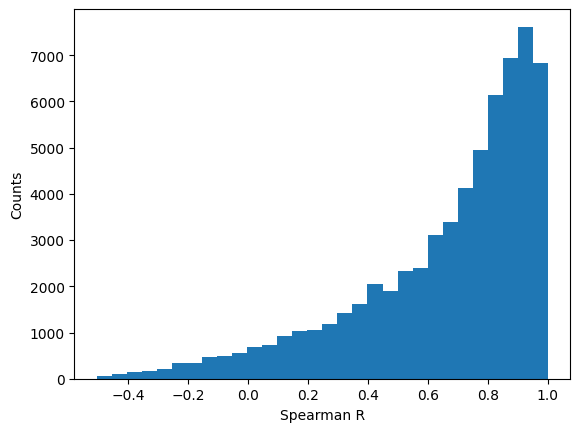

In [37]:
spearman_rs = list(chain(*[elt.values() for elt in path_spearmans.values()]))
fig, ax = plt.subplots()
ax.hist(spearman_rs, bins=30)
ax.set_ylabel("Counts")
ax.set_xlabel("Spearman R")
plt.show()

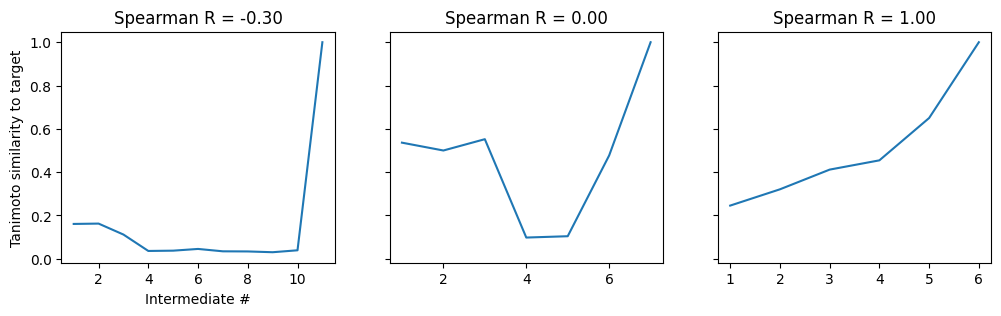

In [38]:
negative_spearman_traces = defaultdict(dict)
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j] + 0.3) < 1e-4:
            negative_spearman_traces[i][j] = path_tanis[i][j]

zero_spearman_traces = defaultdict(dict)
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j]) < 1e-4:
            zero_spearman_traces[i][j] = path_tanis[i][j]

one_spearman_traces = defaultdict(dict)
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j] - 1) < 1e-4:
            one_spearman_traces[i][j] = path_tanis[i][j]

fig, ax = plt.subplots(ncols=3, figsize=(12, 3), sharey=True)
sts = [
    (3115, 2518),
    (1043, 2337),
    (8355, 7054)
]

traces = [negative_spearman_traces, zero_spearman_traces, one_spearman_traces]

plot_it = lambda i, source, target : ax[i].plot(np.arange(1, len(traces[i][source][target]) + 1), traces[i][source][target])

for i, (s, t) in enumerate(sts):
    plot_it(i, s, t)
    ax[i].set_title(f"Spearman R = {path_spearmans[s][t]:.2f}")

ax[0].set_ylabel(f"Tanimoto similarity to target")
ax[0].set_xlabel("Intermediate #")
plt.show()

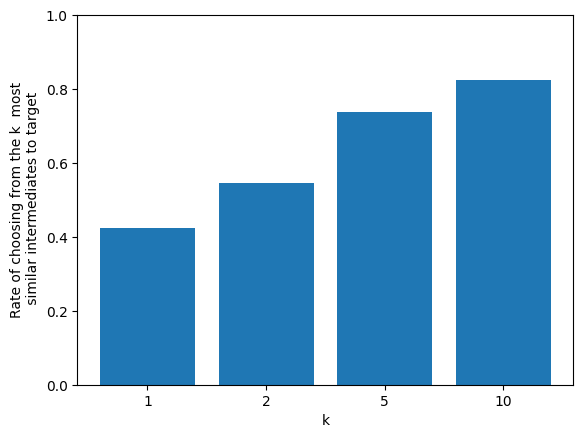

In [41]:
topks = [1, 2, 5, 10]
positive = [0 for _ in range(len(topks))]
n_steps = [0 for _ in range(len(topks))]
for x, k in enumerate(topks):
    for i in path_tanis_all_successors:
        for j in path_tanis_all_successors[i]:
            for step in range(1, len(path_tanis[i][j]) - 1):
                successors = path_tanis_all_successors[i][j][step - 1]
                if len(successors) > k:

                    chosen = path_tanis[i][j][step]
                    n_steps[x] += 1
                    srt_successors = sorted(successors, reverse=True)

                    if srt_successors.index(chosen) < k:
                        positive[x] += 1

fig, ax = plt.subplots()
ax.bar(list(range(len(topks))), [positive[i] / n_steps[i] for i in range(len(topks))], tick_label=topks)
ax.set_ylim(0, 1)
ax.set_xlabel("k")
ax.set_ylabel("Rate of choosing from the k  most\n similar intermediates to target")
plt.show()
